<h2>Projeto Final - Pós-graduação MIT em Data Science, Data Analytics & Machine Learning</h2>



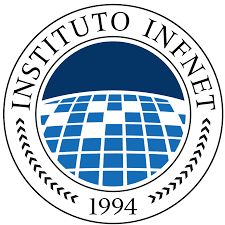

<h1>É possível prever o volume de vendas de lojas do Walmart baseado no histórico de vendas?</h1>



## Sumário
* [Introdução: Descrição do problema](#introduction)
* [Configuração](#setup)
* [Metodologia](#methodology)
* [Análise](#analysis)
* [Resultados e discussões](#results)
* [Conclusão](#conclusion)

## Introdução: <a name="introduction"></a>

A previsão de vendas é uma estimativa de quanto será vendido por uma empresa num determinado período de tempo. Assim, a contribuição da previsão de vendas no processo do planejamento corporativo é amplamente necessário e reconhecido.

Quantas empresas desejariam saber o quanto irá vender no dia seguinte?
Essa resposta facilita a vida das empresas em muitos aspectos, tais como:
- Melhor controle de estoque;
- Qual a quantidade de colaboradores necessárias em épocas de sazonalidade?;
- Previsão de receita;
- Previsão de custos e muitos outros.

*"É preciso haver um norte para que a administração da produção possa trabalhar. A previsão de vendas oferece este direcionamento" (Peinaldo, 2007).*



## Configuração<a name="setup"></a>

Importando as bibliotecas necessárias

In [1]:
!pip install prophet
import warnings

     |████████████████████████████████| 71kB 2.4MB/s 
     |████████████████████████████████| 51kB 3.4MB/s 
     |████████████████████████████████| 184kB 5.0MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-cp37-none-any.whl size=6639264 sha256=b6faeee3981612116fc61d2ffbdf8c9d4be4dbaaff56b1a6b4af9ff3e84170e6
  Stored in directory: /root/.cache/pip/wheels/92/1d/02/bc0a91bd3a84e060722075d2b0b68e875e37ec7dc49451d513
Successfully built prophet
ERROR: fbprophet 0.7.1 has requirement cmdstanpy==0.9.5, but you'll have cmdstanpy 0.9.68 which is incompatible.
  Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from fbprophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM


## Lendo os dados

O objeto de estudo desse trabalho será a série temporal que compreende os dados de venda semanais do Walmart ao longo de vários anos, os quais foram disponibilizados no site Kaggle, disponível no seguinte link:


[Walmart Recruiting - Store Sales Forecasting
Use historical markdown data to predict store sales](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting)

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/naokityokoyama/infnet/main/train.csv')

##Verificando se há informações nulas

In [ ]:
df.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

## Visão geral dos dados

Descrição dos Dados

In [ ]:
df.describe()

,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123
std,12.785297,30.492054,22711.183519
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2079.650000
50%,22.000000,37.000000,7612.030000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


Tamanho da base de dados

In [ ]:
df.shape

(421570, 5)

Detalhes sobre os dados

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


## Pré-processamento dos dados

Convertendo para o formato Date-time

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

Confirmando se os dados foram convertidos

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 13.3 MB


## Visualização dos Dados

Visualizando a série completa

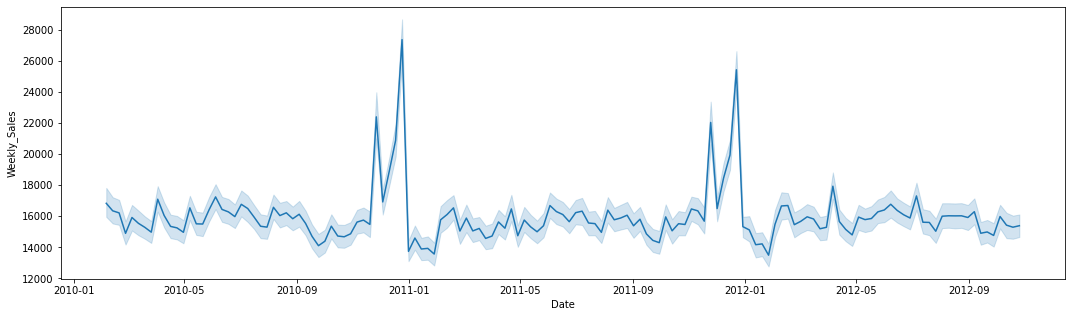

In [ ]:
plt.figure(figsize=(18,5))
sns.lineplot(data=df, x='Date', y='Weekly_Sales')

Verificando vendas negativas

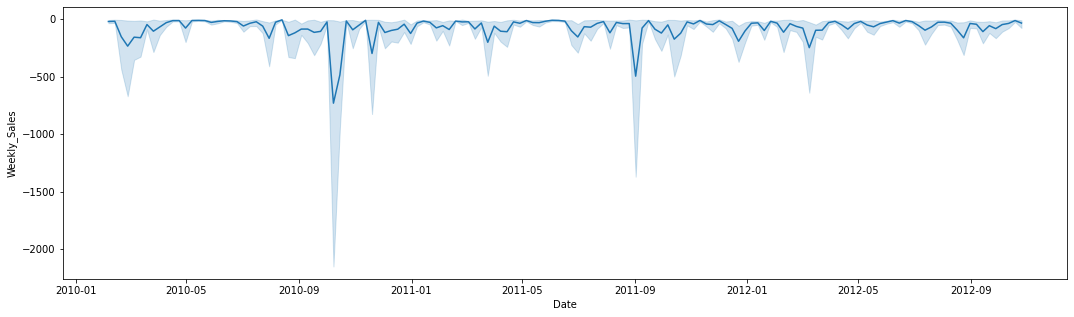

In [ ]:
sales_neg = df.loc[df['Weekly_Sales']<0]
plt.figure(figsize=(18,5))
sns.lineplot(data=sales_neg, x='Date', y='Weekly_Sales')

#Analizando as vendas negativas

In [ ]:
sales_neg.shape[0]

1285

In [ ]:
round (sales_neg.shape[0] / df.shape[0] ,4)*100

0.3

In [ ]:
df.shape[0]

421570

In [ ]:
sales_neg

,Store,Dept,Date,Weekly_Sales,IsHoliday
846,1,6,2012-08-10,-139.65,False
2384,1,18,2012-05-04,-1.27,False
6048,1,47,2010-02-19,-863.00,False
6049,1,47,2010-03-12,-698.00,False
6051,1,47,2010-10-08,-58.00,False
...,...,...,...,...,...
419597,45,80,2010-02-12,-0.43,True
419598,45,80,2010-02-19,-0.27,False
419603,45,80,2010-04-16,-1.61,False
419614,45,80,2010-07-02,-0.27,False


Venda mínima por departamento

In [ ]:
df.groupby('Dept').min()

,Store,Date,Weekly_Sales,IsHoliday
Dept,,,,
1,1,2010-02-05,711.11,False
2,1,2010-02-05,5453.18,False
3,1,2010-02-05,2.00,False
4,1,2010-02-05,4695.19,False
5,1,2010-02-05,-0.04,False
...,...,...,...,...
95,1,2010-02-05,11158.06,False
96,1,2010-02-05,-63.80,False
97,1,2010-02-05,-9.92,False


#Criando uma lista com as vendas mínimas por departamento

In [ ]:
lista = []
for i in range(1,100):
  lista.append (df[df.Dept==i]['Weekly_Sales'].min())

In [ ]:
df_dp_min = pd.DataFrame(lista)

Departamentos que não existem : 15
53
57
61
62
63
64
66
68
69
70
73
75
76
84
86
88
89



In [ ]:
lista_dp = []
lista_dep_vazios = [15, 53, 57, 61, 62, 63, 64, 66, 68, 69, 70, 73, 75, 76, 84, 86, 88, 89]
for dep in lista_dep_vazios:
  lista_dp.append(df[df.Dept==dep])

In [ ]:
lista_dp

[Empty DataFrame
 Columns: [Store, Dept, Date, Weekly_Sales, IsHoliday]
 Index: [], Empty DataFrame
 Columns: [Store, Dept, Date, Weekly_Sales, IsHoliday]
 Index: [], Empty DataFrame
 Columns: [Store, Dept, Date, Weekly_Sales, IsHoliday]
 Index: [], Empty DataFrame
 Columns: [Store, Dept, Date, Weekly_Sales, IsHoliday]
 Index: [], Empty DataFrame
 Columns: [Store, Dept, Date, Weekly_Sales, IsHoliday]
 Index: [], Empty DataFrame
 Columns: [Store, Dept, Date, Weekly_Sales, IsHoliday]
 Index: [], Empty DataFrame
 Columns: [Store, Dept, Date, Weekly_Sales, IsHoliday]
 Index: [], Empty DataFrame
 Columns: [Store, Dept, Date, Weekly_Sales, IsHoliday]
 Index: [], Empty DataFrame
 Columns: [Store, Dept, Date, Weekly_Sales, IsHoliday]
 Index: [], Empty DataFrame
 Columns: [Store, Dept, Date, Weekly_Sales, IsHoliday]
 Index: [], Empty DataFrame
 Columns: [Store, Dept, Date, Weekly_Sales, IsHoliday]
 Index: [], Empty DataFrame
 Columns: [Store, Dept, Date, Weekly_Sales, IsHoliday]
 Index: [], Emp

Departamentos Vazios : pulou linhas

In [ ]:
df[df.Dept==1]['Weekly_Sales'].describe()

count      6435.000000
mean      19213.485088
std       15102.373853
min         711.110000
25%       10423.465000
50%       15314.910000
75%       23135.595000
max      172225.550000
Name: Weekly_Sales, dtype: float64

In [ ]:
df[df.Dept==1].describe()

,Store,Dept,Weekly_Sales
count,6435.000000,6435.0,6435.000000
mean,23.000000,1.0,19213.485088
std,12.988182,0.0,15102.373853
min,1.000000,1.0,711.110000
25%,12.000000,1.0,10423.465000
50%,23.000000,1.0,15314.910000
75%,34.000000,1.0,23135.595000
max,45.000000,1.0,172225.550000


#Criando uma lista de lojas

In [ ]:
lista_lojas = []
for loja in range(1,46):
  lista_lojas.append(df.loc[df['Store']==loja].shape[0])

In [ ]:
df.loc[df['Store']==1]

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
...,...,...,...,...,...
10239,1,99,2012-08-31,20.06,False
10240,1,99,2012-09-07,0.05,True
10241,1,99,2012-09-14,0.03,False
10242,1,99,2012-10-05,635.00,False


In [ ]:
df.loc[df['Store']==3]

,Store,Dept,Date,Weekly_Sales,IsHoliday
20482,3,1,2010-02-05,6453.58,False
20483,3,1,2010-02-12,12748.72,True
20484,3,1,2010-02-19,8918.31,False
20485,3,1,2010-02-26,4992.00,False
20486,3,1,2010-03-05,5172.73,False
...,...,...,...,...,...
29513,3,98,2012-06-01,49.50,False
29514,3,98,2012-06-29,94.50,False
29515,3,98,2012-07-06,40.50,False
29516,3,98,2012-07-13,9.00,False


In [ ]:
pd.DataFrame(lista_lojas)

,0
0,10244
1,10238
2,9036
3,10272
4,8999
5,10211
6,9762
7,9895
8,8867
9,10315


In [ ]:
df

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False


#Visualizando as lojas com maiores vendas

In [ ]:
top_vendas = pd.DataFrame(df.groupby('Store')['Weekly_Sales'].sum()).reset_index()

In [ ]:
top_vendas

,Store,Weekly_Sales
0,1,2.224028e+08
1,2,2.753824e+08
2,3,5.758674e+07
3,4,2.995440e+08
4,5,4.547569e+07
5,6,2.237561e+08
6,7,8.159828e+07
7,8,1.299512e+08
8,9,7.778922e+07
9,10,2.716177e+08


**<h2>Gráfico 3: Total de vendas por loja</h2>**

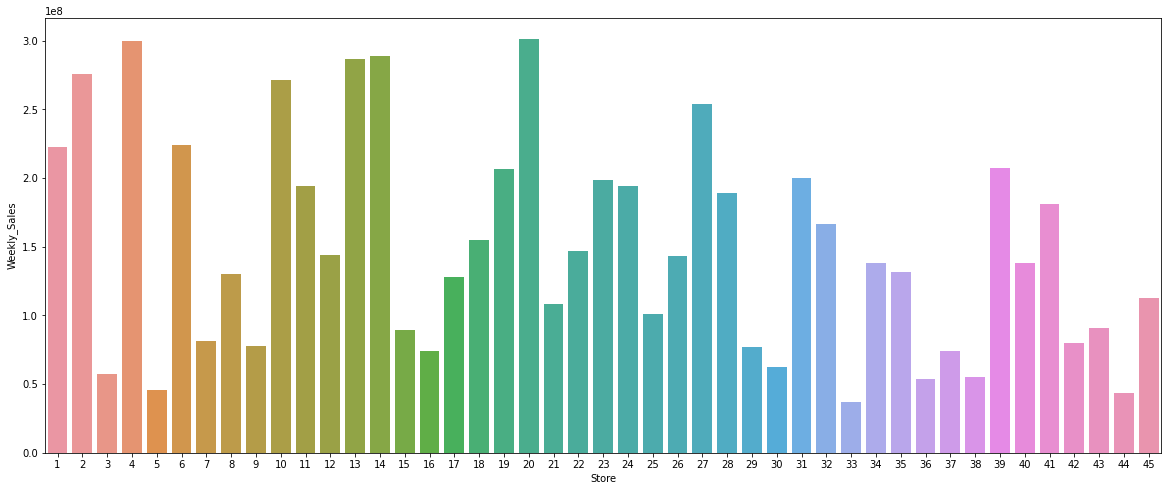

In [ ]:
plt.figure(figsize=(20,8))
sns.barplot(data=top_vendas, x='Store', y='Weekly_Sales')

#**Departamentos com maiores vendas**

In [ ]:
top_dep = pd.DataFrame(df.groupby('Dept')['Weekly_Sales'].sum()).reset_index()

In [ ]:
top_dep

,Dept,Weekly_Sales
0,1,1.236388e+08
1,2,2.806112e+08
2,3,7.589245e+07
3,4,1.671467e+08
4,5,1.356074e+08
...,...,...
76,95,4.493202e+08
77,96,7.383392e+07
78,97,8.949651e+07
79,98,3.982892e+07


**Gráfico 4: Somatório de vendas por departamento**

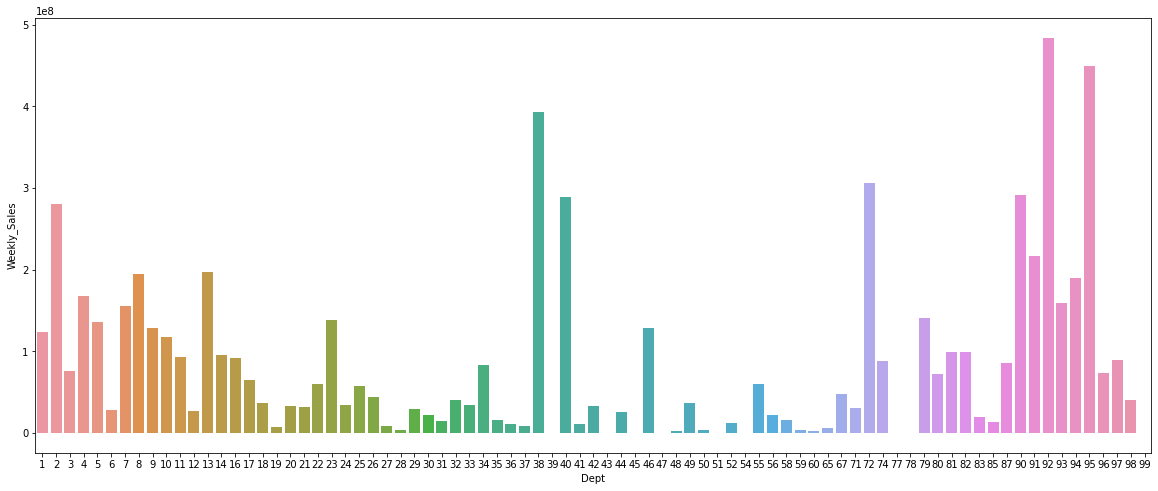

In [ ]:
plt.figure(figsize=(20,8))
sns.barplot(data=top_dep, x='Dept', y='Weekly_Sales')

# Começando a construção do modelo apenas para a Loja 1

In [16]:
loja_1 = df[df['Store']==1]

In [18]:
loja_1 = loja_1.drop(['Store'	,'Dept'], axis=1)

In [13]:
loja_1['Date'].nunique()

143

Convertendo para Data Frame e agrupando as vendas por data

In [22]:
loja_1 = loja_1.groupby('Date').sum().reset_index()
mapa = {0:False, 71:True, 72:True, 73:True}
loja_1.IsHoliday = loja_1.IsHoliday.map(mapa)

Convertendo para Date Time

In [26]:
loja_1['Date'] = pd.to_datetime(loja_1['Date'])

Separação treino e test

In [31]:
treino = loja_1.iloc[0:131]
test = loja_1.tail(12)

FB Prophet

In [33]:
X = pd.DataFrame(loja_1[['Date', 'Weekly_Sales']])
X = X.rename(columns={'Date':'ds', 'Weekly_Sales':'y'})
X['ds'] = pd.to_datetime(X['ds'])

In [34]:
m = Prophet(yearly_seasonality=True)
m.add_country_holidays(country_name='US')
m.fit(X)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [35]:
future = m.make_future_dataframe(periods=12, freq='w')

In [36]:
future.tail(12)

,ds
143,2012-10-28
144,2012-11-04
145,2012-11-11
146,2012-11-18
147,2012-11-25
148,2012-12-02
149,2012-12-09
150,2012-12-16
151,2012-12-23
152,2012-12-30


In [37]:
forecast = m.predict(future)

In [38]:
round(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]).tail(12)

,ds,yhat,yhat_lower,yhat_upper
143,2012-10-28,1534891.0,1417141.0,1656893.0
144,2012-11-04,1592087.0,1470668.0,1716601.0
145,2012-11-11,1661840.0,1546267.0,1785874.0
146,2012-11-18,1760214.0,1636928.0,1870826.0
147,2012-11-25,1791335.0,1677823.0,1914721.0
148,2012-12-02,1815952.0,1704245.0,1934298.0
149,2012-12-09,1878487.0,1758107.0,1986619.0
150,2012-12-16,1958251.0,1839268.0,2076938.0
151,2012-12-23,1967920.0,1851321.0,2083171.0
152,2012-12-30,1840441.0,1721157.0,1954657.0


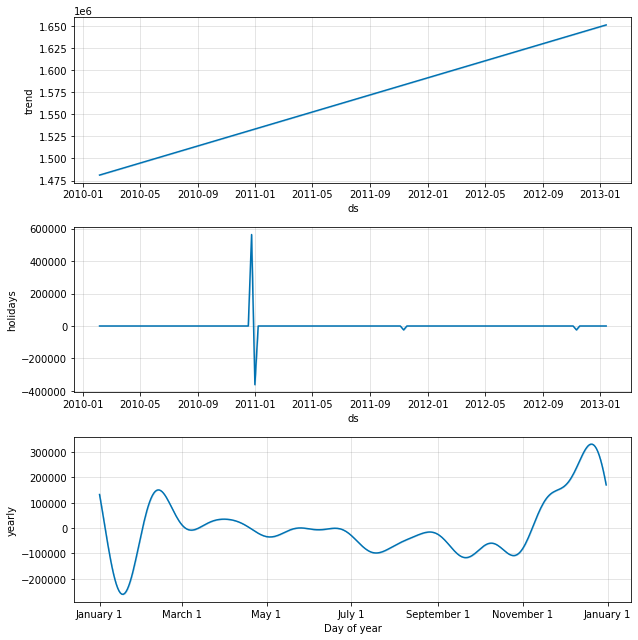

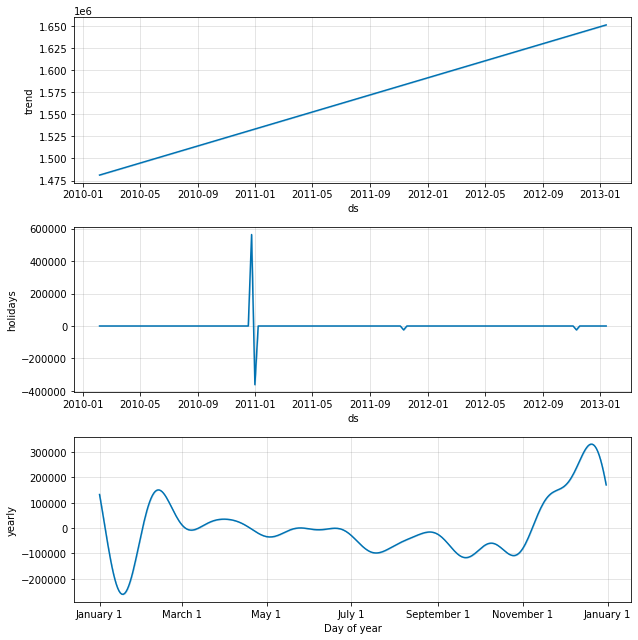

In [39]:
 m.plot_components(forecast)

In [40]:
plot_plotly(m, forecast)

In [70]:
fore = pd.DataFrame(round(forecast['yhat']).tail(12)).reset_index()
fore = fore.drop('index', axis=1)

In [75]:
test = test.reset_index().drop('index', axis=1)

In [80]:
resultado_final_prophet_loja1 = pd.concat([test, fore], axis=1).drop('IsHoliday', axis=1)
resultado_final_prophet_loja1['diff'] = resultado_final_prophet_loja1['Weekly_Sales'] -  resultado_final_prophet_loja1['yhat']
resultado_final_prophet_loja1['%'] =  (resultado_final_prophet_loja1['diff']  / resultado_final_prophet_loja1['Weekly_Sales'])*100 

In [81]:
resultado_final_prophet_loja1

,Date,Weekly_Sales,yhat,diff,%
0,2012-08-10,1592409.97,1534891.0,57518.97,3.612070
1,2012-08-17,1597868.05,1592087.0,5781.05,0.361798
2,2012-08-24,1494122.38,1661840.0,-167717.62,-11.225159
3,2012-08-31,1582083.40,1760214.0,-178130.60,-11.259242
4,2012-09-07,1661767.33,1791335.0,-129567.67,-7.796980
5,2012-09-14,1517428.87,1815952.0,-298523.13,-19.672957
6,2012-09-21,1506126.06,1878487.0,-372360.94,-24.723093
7,2012-09-28,1437059.26,1958251.0,-521191.74,-36.267937
8,2012-10-05,1670785.97,1967920.0,-297134.03,-17.784087
9,2012-10-12,1573072.81,1840441.0,-267368.19,-16.996555


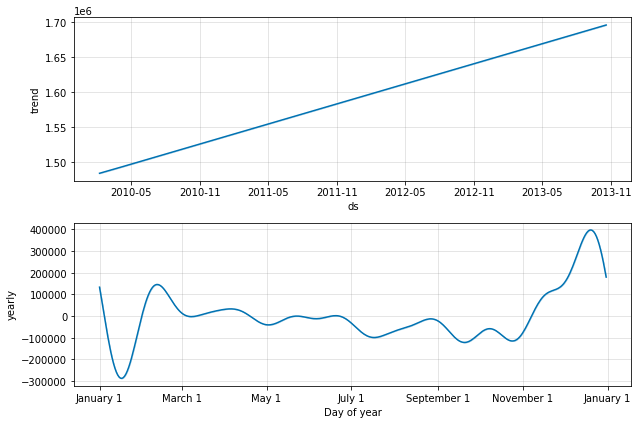

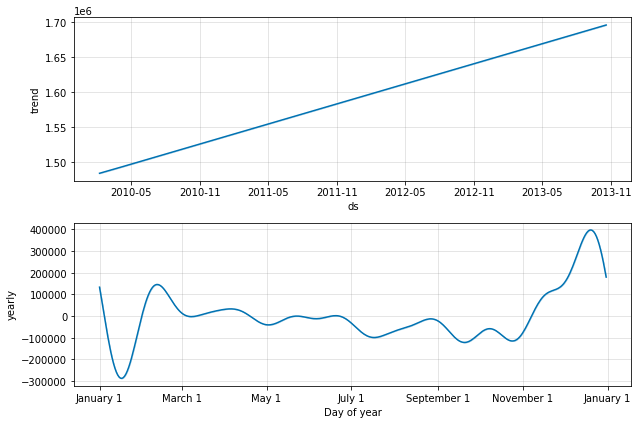

In [ ]:
 m.plot_components(forecast)

RNN

In [82]:
base_treino = treino['Weekly_Sales'].values
base_teste = test['Weekly_Sales'].values 

In [83]:
min = MinMaxScaler()
base_treino = base_treino.reshape(-1,1)
base_treino = min.fit_transform(base_treino)
base_treino = base_treino[:,0]

In [84]:
previsores = []
preco_real = []

for i in range(12, treino.shape[0]):
  previsores.append(base_treino[i-12:i])
  preco_real.append(base_treino[i])

In [85]:
previsores, preco_real = np.array(previsores), np.array(preco_real)

In [86]:
previsores = np.reshape(previsores, (previsores.shape[0], previsores.shape[1], 1))

In [ ]:
regressor = Sequential()

regressor.add(LSTM(units=100, return_sequences=True, input_shape = (12,1)))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units=50, return_sequences=False))
regressor.add(Dropout(0.3))

regressor.add(Dense(units=1, activation='linear'))

regressor.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

regressor.fit(previsores, preco_real, epochs=2000, batch_size=15)

Base de teste

In [89]:
preco_real_test = test['Weekly_Sales'].values
base_completa = pd.concat([treino['Weekly_Sales'], test['Weekly_Sales']], axis=0)

In [90]:
entradas = base_completa[len(base_completa)-len(test)-12:].values

In [91]:
entradas = entradas.reshape(-1,1)
entradas = min.transform(entradas)
entradas = entradas[:,0]

In [92]:
x_test = []
for i in range(12, test.shape[0]+12):
  x_test.append(entradas[i-12:i])

In [93]:
x_test = np.array(x_test)  

In [94]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [95]:
previsoes = regressor.predict(x_test)

In [96]:
previsoes = min.inverse_transform(previsoes)

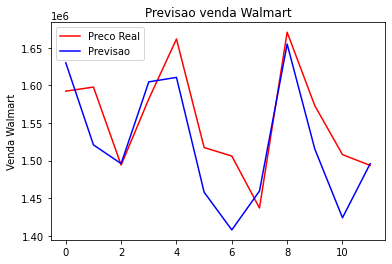

In [97]:
plt.plot(preco_real_test, color='r', label='Preco Real')
plt.plot(previsoes, color='b', label='Previsao')
plt.title('Previsao venda Walmart')
plt.ylabel('Venda Walmart')
plt.legend()
plt.show()